# 梯度提升

## 1. 梯度提升

梯度提升是指一类集成机器学习算法，可用于分类或回归预测问题。

梯度提升也称为梯度树增强，随机梯度增强（扩展）和梯度增强机，简称GBM(Gradient Boosting Machine)。

集成是根据决策树模型构建的，一次将一棵树添加到集合中，并进行调整以纠正先前模型造成的预测误差。

使用任何任意的微分损失函数和梯度下降优化算法对模型进行拟合。这给该技术起了名字，即“梯度提升”，因为随着模型的拟合，损耗梯度被最小化，就像神经网络一样。

集成算法最重要的超参数：

* 模型使用的决策树的数量
* 学习率(learning rate)
* 树的最大深度
* 树的最小权重
* 正则化参数$\alpha$和$\lambda$

梯度提升算法有很多不同的实现，最常用的是sklearn提供的接口。此外还有3个广泛使用的模型，分别由XGBoost, LightGBM, CatBoost库实现。

参考资料：

* [用sklearn, xgboost, lightgbm, catboost实现梯度提升](https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/)
* [梯度提升算法入门](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
* [XGBoost入门简介](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/)
* [如何调整梯度提升算法](https://machinelearningmastery.com/configure-gradient-boosting-algorithm/)

In [18]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("ggplot")

warnings.filterwarnings("ignore")

## 2. 准备数据

分类问题使用Pima-Indians-Diabetes数据集，数据集包含768个观测值和8个特征，目标预测是否患糖尿病。

特征解释：
   
* Pregnancies: 怀孕次数
* Glucose: 口服葡萄糖耐量测试中2小时的血浆葡萄糖浓度
* BloodPressure: 舒张压（毫米汞柱）
* SkinThickness: 三头肌皮肤褶皱厚度（毫米）
* Insulin: 2小时血清胰岛素（mu U / ml）
* BMI: 体重指数（体重（kg）/（身高（m））^ 2）
* DiatetesPedigreeFunction: 糖尿病谱系功能
* Age: 年龄（岁）

目标变量(Outcome)：1：糖尿病检测呈阳性；0：检测阴性

In [19]:
diabetes = pd.read_csv("./datasets/diabetes.csv")
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


回归问题使用boston_housing数据集，目标是预测房屋价格均值。

In [20]:
from sklearn.datasets import load_boston

boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df["target"] = boston.target

boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


## 3. sklearn实现

### 3.1 分类问题

sklearn提供接口GradientBoostingClassifier来实现GBM。

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [22]:
# 拆分训练集和检验集
X, y = diabetes.iloc[:, 0:8], diabetes.iloc[:, 8]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# 创建模型，使用默认超参数
model = GradientBoostingClassifier()

# 拟合数据
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 评估预测精度
report = metrics.classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       143
           1       0.73      0.74      0.73        88

    accuracy                           0.80       231
   macro avg       0.78      0.79      0.78       231
weighted avg       0.80      0.80      0.80       231



### 3.2 回归问题

sklearn提供接口GradientBoostingRegressor实现GBM。

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [24]:
# 拆分训练集和检验集
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, test_size=0.3, random_state=123)

# 创建模型
model = GradientBoostingRegressor()

# 拟合数据
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 评估预测精度
print("MAE: %.2f" % metrics.mean_absolute_error(y_test, y_pred))
print("MSE: %.2f" % metrics.mean_squared_error(y_test, y_pred))
print("R2: %.2f" % metrics.r2_score(y_test, y_pred))

MAE: 2.32
MSE: 13.08
R2: 0.84


Text(0.5, 1.0, 'Observation vs Predition')

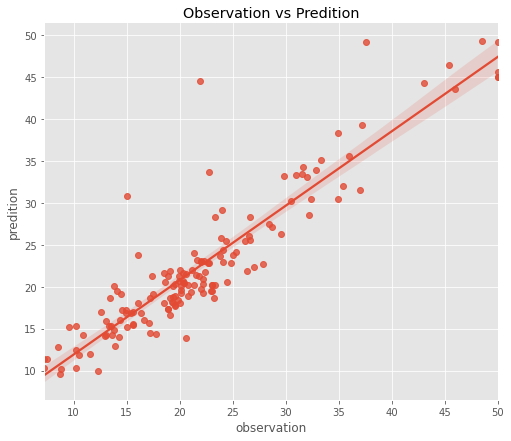

In [31]:
data = pd.DataFrame({"observation": y_test, "predition": y_pred})
lmplot = sns.lmplot(x="observation", y="predition", data=data, height=6, aspect=1.2)
ax = lmplot.ax
ax.set_title("Observation vs Predition")

## 4. XGBoost

XGBoost: Extreme Gradient Boosting, 是梯度提升算法的有效实现。

XGBoost提供两个接口，分别解决分类和回归问题：

* 分类：XGBClassifier
* 回归：XGBRegressor

In [25]:
import xgboost

print(xgboost.__version__)

1.1.1


### 4.1 分类问题

In [26]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBClassifier

# 拆分数据集
X, y = diabetes.iloc[:, 0:8], diabetes.iloc[:, 8]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# 创建模型，使用默认超参数
model = xgboost.XGBClassifier()

# 拟合数据
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 评估预测精度
report = metrics.classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       143
           1       0.69      0.67      0.68        88

    accuracy                           0.76       231
   macro avg       0.74      0.74      0.74       231
weighted avg       0.76      0.76      0.76       231



### 4.2 回归问题

In [27]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBRegressor

# 拆分训练集和检验集
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, test_size=0.3, random_state=123)

# 创建模型
model = XGBRegressor()

# 拟合数据
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 评估预测精度
print("MAE: %.2f" % metrics.mean_absolute_error(y_test, y_pred))
print("MSE: %.2f" % metrics.mean_squared_error(y_test, y_pred))
print("R2: %.2f" % metrics.r2_score(y_test, y_pred))

MAE: 2.43
MSE: 13.45
R2: 0.83


## 5. LightGBM

LightGBM: Light Gradient Boosting Machine，是梯度提升算法的一种实现，它的优势在于训练速度极快。

LightGBM提供两个接口，分别用于分类和回归问题：

* 分类：LGBMClassifier
* 回归：LGBMRegressor

In [33]:
import lightgbm

print(lightgbm.__version__)

2.3.1


### 5.1 分类

In [35]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from lightgbm import LGBMClassifier

# 拆分数据集
X, y = diabetes.iloc[:, 0:8], diabetes.iloc[:, 8]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# 创建模型，使用默认超参数
model = LGBMClassifier()

# 拟合数据
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 评估预测精度
report = metrics.classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       143
           1       0.66      0.69      0.68        88

    accuracy                           0.75       231
   macro avg       0.73      0.74      0.74       231
weighted avg       0.75      0.75      0.75       231



### 5.2 回归

In [36]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from lightgbm import LGBMRegressor

# 拆分训练集和检验集
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, test_size=0.3, random_state=123)

# 创建模型
model = LGBMRegressor()

# 拟合数据
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 评估预测精度
print("MAE: %.2f" % metrics.mean_absolute_error(y_test, y_pred))
print("MSE: %.2f" % metrics.mean_squared_error(y_test, y_pred))
print("R2: %.2f" % metrics.r2_score(y_test, y_pred))

MAE: 2.53
MSE: 17.11
R2: 0.79
